In [129]:
import cv2
import json
from matplotlib import pyplot as plt
import numpy as np
import os
import random

# import a lot of things from keras:
# sequential model
from keras.models import Sequential

# layers
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, RandomFlip, RandomRotation, RandomContrast, RandomBrightness

# loss function
from keras.metrics import categorical_crossentropy

# callback functions
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# convert data to categorial vector representation
from keras.utils import to_categorical

# nice progress bar for loading data
from tqdm.notebook import tqdm

# helper function for train/test split
from sklearn.model_selection import train_test_split

# import confusion matrix helper function
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# import pre-trained model
from keras.applications.vgg16 import VGG16

# include only those gestures
CONDITIONS = ['like', 'stop']

# image size
IMG_SIZE = 64
SIZE = (IMG_SIZE, IMG_SIZE)

# number of color channels we want to use
# set to 1 to convert to grayscale
# set to 3 to use color images
COLOR_CHANNELS = 3

#added
PATH = '../gesture_dataset_sample'

## helper function to load and parse annotations

In [130]:
annotations = dict()

for condition in CONDITIONS:
    with open(f'{PATH}/_annotations/{condition}.json') as f:
        annotations[condition] = json.load(f)

In [131]:
# pretty-print first element
print(json.dumps(annotations['like']['0014182f-d756-42b3-896c-c52de76926bb'], indent=2))

{
  "bboxes": [
    [
      0.38056273,
      0.35650891,
      0.17322347,
      0.10461114
    ]
  ],
  "labels": [
    "like"
  ],
  "landmarks": [
    [
      [
        0.5497169170918876,
        0.4276043615779976
      ],
      [
        0.5218336293004483,
        0.40536586667786917
      ],
      [
        0.48288133220125257,
        0.3930262243722419
      ],
      [
        0.4501841862302019,
        0.37981099195030416
      ],
      [
        0.44251365410099686,
        0.36620499322043343
      ],
      [
        0.43138297470865106,
        0.406093902776592
      ],
      [
        0.4072660997339628,
        0.4073950234480344
      ],
      [
        0.42588200316326846,
        0.40612291879594015
      ],
      [
        0.4441470003072778,
        0.4049221293588555
      ],
      [
        0.4314493576491367,
        0.4212979654419442
      ],
      [
        0.42096276272263283,
        0.4180224457320293
      ],
      [
        0.43966095717106257,
      

## helper function to pre-process images (color channel conversion and resizing)

In [132]:
def preprocess_image(img):
    if COLOR_CHANNELS == 1:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_resized = cv2.resize(img, SIZE)
    return img_resized

## load images and annotations

In [5]:
images = [] # stores actual image data
labels = [] # stores labels (as integer - because this is what our network needs)
label_names = [] # maps label ints to their actual categories so we can understand predictions later

# loop over all conditions
# loop over all files in the condition's directory
# read the image and corresponding annotation
# crop image to the region of interest
# preprocess image
# store preprocessed image and label in corresponding lists
for condition in CONDITIONS:
    for filename in tqdm(os.listdir(f'{PATH}/{condition}')):
        # extract unique ID from file name
        UID = filename.split('.')[0]
        img = cv2.imread(f'{PATH}/{condition}/{filename}')
        
        # get annotation from the dict we loaded earlier
        try:
            annotation = annotations[condition][UID]
        except Exception as e:
            print(e)
            continue
        
        # iterate over all hands annotated in the image
        for i, bbox in enumerate(annotation['bboxes']):
            # annotated bounding boxes are in the range from 0 to 1
            # therefore we have to scale them to the image size
            x1 = int(bbox[0] * img.shape[1])
            y1 = int(bbox[1] * img.shape[0])
            w = int(bbox[2] * img.shape[1])
            h = int(bbox[3] * img.shape[0])
            x2 = x1 + w
            y2 = y1 + h
            
            # crop image to the bounding box and apply pre-processing
            crop = img[y1:y2, x1:x2]
            preprocessed = preprocess_image(crop)
            
            # get the annotated hand's label
            # if we have not seen this label yet, add it to the list of labels
            label = annotation['labels'][i]
            if label not in label_names:
                label_names.append(label)
            
            label_index = label_names.index(label)
            
            images.append(preprocessed)
            labels.append(label_index)

  0%|          | 0/250 [00:00<?, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

## let's have a look at one of the images

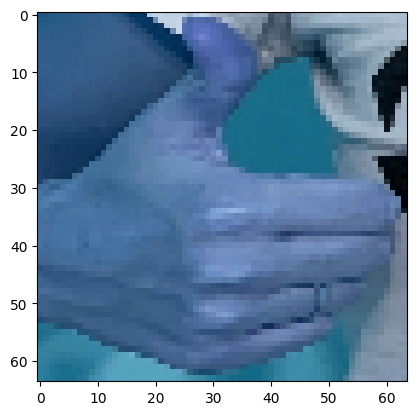

In [133]:
plt.imshow(random.sample(images, 1)[0])

## split data set into train and test

x is for the actual data, y is for the label (this is convention)

In [134]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

512
128
512
128


## transform data sets into a format compatible with our neural network

image data has to be a numpy array with following dimensions: [image_id, y_axis, x_axis, color_channels]

furthermore, scale all values to a range of 0 to 1

training data has to be converted to a categorial vector ("one hot"):

[3] --> [0, 0, 0, 1, 0, ..., 0]

In [135]:
X_train = np.array(X_train).astype('float32')
X_train = X_train / 255.

X_test = np.array(X_test).astype('float32')
X_test = X_test / 255.

y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

train_label = y_train_one_hot
test_label = y_test_one_hot

X_train = X_train.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)
X_test = X_test.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)

print(X_train.shape, X_test.shape, train_label.shape, test_label.shape)

(512, 64, 64, 3) (128, 64, 64, 3) (512, 3) (128, 3)


<span style="color:red">Ich habe die Anzahl der Convolution Layer hier angepasst, indem ich eine zusätzliche Variable hinzugefügt habe.</span>

In [158]:
# variables for hyperparameters
batch_size = 8
epochs = 50
num_classes = len(label_names)
activation = 'relu'
activation_conv = 'leaky_relu'  # LeakyReLU
layer_count = 2
num_neurons = 64
NUMBER_OF_CONVOLUTION_LAYERS = 3 #change this!!

# define model structure
# with keras, we can use a model's add() function to add layers to the network one by one
model = Sequential()

# data augmentation (this can also be done beforehand - but don't augment the test dataset!)
model.add(RandomFlip('horizontal'))
model.add(RandomContrast(0.1))
#model.add(RandomBrightness(0.1))
#model.add(RandomRotation(0.2))

# first, we add some convolution layers followed by max pooling
# model.add(Conv2D(64, kernel_size=(9, 9), activation=activation_conv, input_shape=(SIZE[0], SIZE[1], COLOR_CHANNELS), padding='same'))
# model.add(MaxPooling2D(pool_size=(4, 4), padding='same'))

# model.add(Conv2D(32, (5, 5), activation=activation_conv, padding='same'))
# model.add(MaxPooling2D(pool_size=(3, 3), padding='same'))

for i in range(NUMBER_OF_CONVOLUTION_LAYERS):
    model.add(Conv2D(32, (3, 3), activation=activation_conv, padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

# dropout layers can drop part of the data during each epoch - this prevents overfitting
model.add(Dropout(0.2))

# after the convolution layers, we have to flatten the data so it can be fed into fully connected layers
model.add(Flatten())

# add some fully connected layers ("Dense")
for i in range(layer_count - 1):
    model.add(Dense(num_neurons, activation=activation))

model.add(Dense(num_neurons, activation=activation))

# for classification, the last layer has to use the softmax activation function, which gives us probabilities for each category
model.add(Dense(num_classes, activation='softmax'))

# specify loss function, optimizer and evaluation metrics
# for classification, categorial crossentropy is used as a loss function
# use the adam optimizer unless you have a good reason not to
model.compile(loss=categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

# define callback functions that react to the model's behavior during training
# in this example, we reduce the learning rate once we get stuck and early stopping
# to cancel the training if there are no improvements for a certain amount of epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)

## now, we can train the model using the fit() function
## this will take a while

In [159]:
history = model.fit(
    X_train,
    train_label,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, test_label),
    callbacks=[reduce_lr, stop_early]
)

Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.3983 - loss: 1.0614 - val_accuracy: 0.5156 - val_loss: 1.0112 - learning_rate: 0.0010
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5092 - loss: 0.9567 - val_accuracy: 0.4375 - val_loss: 0.9812 - learning_rate: 0.0010
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6332 - loss: 0.8318 - val_accuracy: 0.8359 - val_loss: 0.4571 - learning_rate: 0.0010
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.8129 - loss: 0.4225 - val_accuracy: 0.6797 - val_loss: 0.8582 - learning_rate: 0.0010
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.8358 - loss: 0.4122 - val_accuracy: 0.8906 - val_loss: 0.3433 - learning_rate: 0.0010
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9456 - loss: 0.1724 - val_accuracy: 0.8828 - val_loss: 0.4284 - learning_rate: 0.0010
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9598 - loss: 0.1604 - val_acc

In [160]:
# let's have a look at our model
model.summary()

Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_flip_21 (RandomFlip)     │ (8, 64, 64, 3)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_contrast_21              │ (8, 64, 64, 3)         │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_55 (Conv2D)              │ (8, 64, 64, 32)        │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_55 (MaxPooling2D) │ (8, 32, 32, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_56 (Conv2D)              │ (8, 32, 32, 32)        │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_56 (MaxPooling2D) │ (8, 16, 16, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_57 (Conv2D)              │ (8, 16, 16, 32)        │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_57 (MaxPooling2D) │ (8, 8, 8, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (8, 8, 8, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_21 (Flatten)            │ (8, 2048)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_66 (Dense)                │ (8, 64)                │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_67 (Dense)                │ (8, 64)                │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_68 (Dense)                │ (8, 3)                 │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 464,651 (1.77 MB)

 Trainable params: 154,883 (605.01 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 309,768 (1.18 MB)

## Plot accuracy and loss of the training process

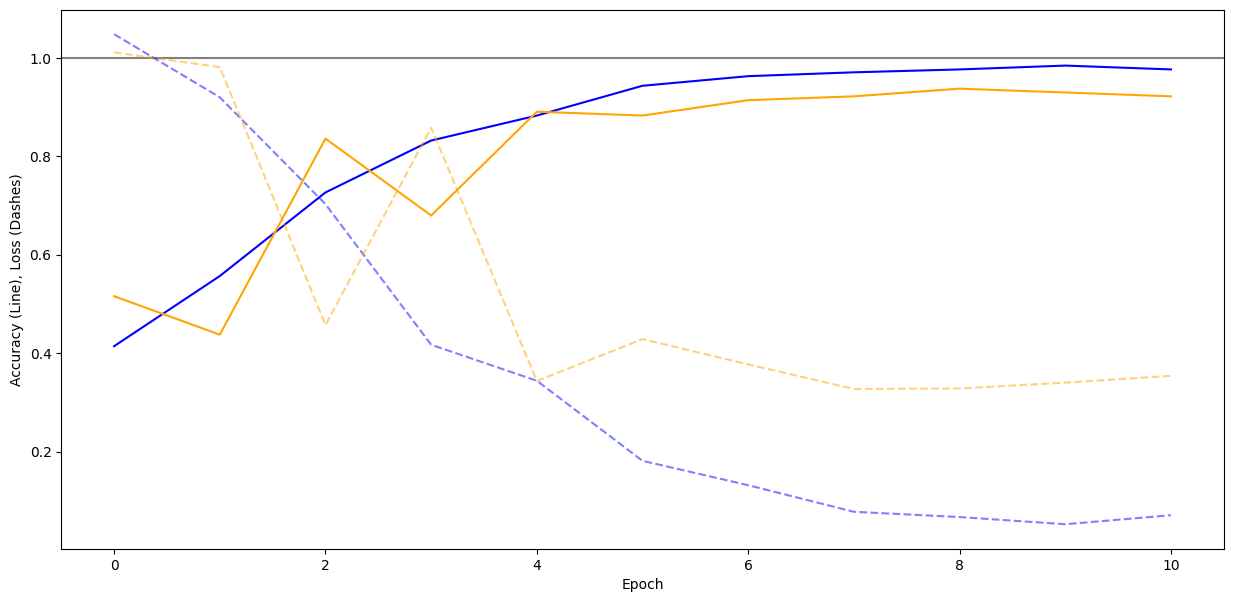

In [161]:
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

fig = plt.figure(figsize=(15, 7))
ax = plt.gca()

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

ax.axhline(1, color='gray')

plt.plot(accuracy, color='blue')
plt.plot(val_accuracy, color='orange')
plt.plot(loss, '--', color='blue', alpha=0.5)
plt.plot(val_loss, '--', color='orange', alpha=0.5)

plt.savefig('accuracy_loss_3.png', format='png') #change name here

## saving the model

the function will create a directory for your model and save structure and weights in there

sometimes you will see the .h5 format being used - even though this is a bit faster and needs less space, it comes with its limitations and isn't used that much any more

In [90]:
#model.save('gesture_recognition.keras')
model.save('convolution_layers_5.keras') #change name here

# and this is how you load the model
# model = keras.models.load_model("gesture_recognition")

## Inference Times

In [165]:
import time

start_time = time.time()
predictions = model.predict(X_test)
end_time = time.time()

# Inference Time berechnen
inference_time = end_time - start_time
print(f'Inference Time: {inference_time:.4f} seconds')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
Inference Time: 0.1023 seconds


## visualize classification results with a confusion matrix

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step 
before [[3.78672645e-04 9.98003185e-01 1.61818729e-03]
 [9.99997020e-01 2.61801958e-08 2.97206770e-06]
 [9.99970734e-01 2.01547232e-06 2.72818888e-05]
 [1.06635224e-03 9.96715307e-01 2.21828069e-03]
 [2.25683441e-03 9.95578408e-01 2.16471986e-03]
 [9.92471397e-01 2.39066430e-04 7.28950184e-03]
 [9.87762630e-01 4.84845426e-04 1.17524490e-02]
 [1.48018003e-01 8.42506766e-01 9.47522745e-03]
 [9.99798954e-01 4.51307596e-06 1.96509776e-04]
 [1.54832297e-03 9.94841158e-01 3.61049501e-03]
 [3.69701087e-02 2.43299723e-01 7.19730198e-01]
 [9.99999523e-01 4.72078234e-08 5.23341214e-07]
 [6.87957424e-08 9.99998689e-01 1.23587131e-06]
 [5.10403970e-06 9.99955118e-01 3.97659023e-05]
 [6.17334008e-01 3.52767676e-01 2.98982859e-02]
 [5.16187251e-02 8.75363111e-01 7.30182305e-02]
 [5.67309144e-05 8.22448237e-06 9.99935031e-01]
 [1.09395378e-05 1.66141544e-05 9.99972522e-01]
 [9.99998450e-01 1.79007060e-07 1.32507444e-06]
 [4.67335386e-03 4.44787322e-03 9.90878761

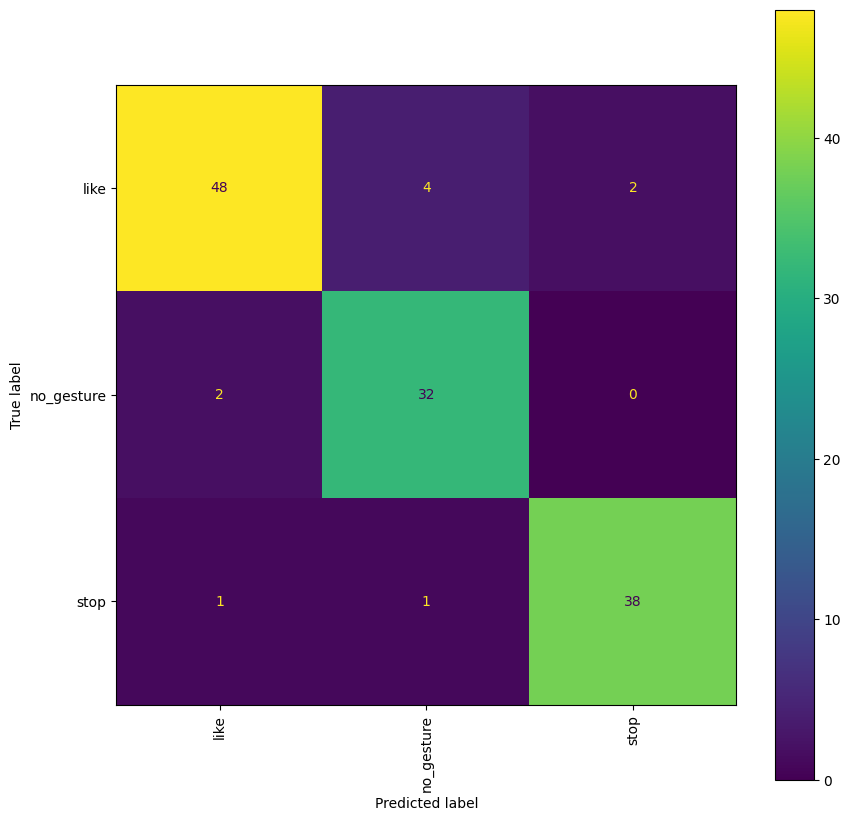

In [162]:
# let the model make predictions for our training data
y_predictions = model.predict(X_test)

# we get a 2D numpy array with probabilities for each category
print('before', y_predictions)

# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions = np.argmax(y_predictions, axis=1)

print('probabilities', y_predictions)

# create and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_predictions)

fig = plt.figure(figsize=(10, 10))

ConfusionMatrixDisplay(conf_matrix, display_labels=label_names).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')

plt.savefig('confusion_matrices/confusion_matrix_3.png', format='png') #change name here
pass

## let's test our model in action

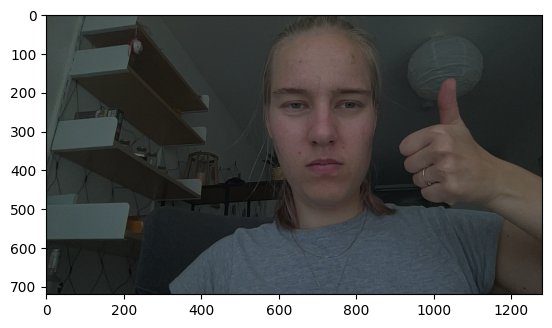

In [28]:
cap = cv2.VideoCapture(1) # 1 for MAC
ret, frame = cap.read()
if COLOR_CHANNELS == 1:
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
else: frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) #added this for normal pic
cap.release()
plt.imshow(frame)

Das Bild war bei mir sehr dunkel, deswegen hier ein wenig heller (generiert durch GPT):

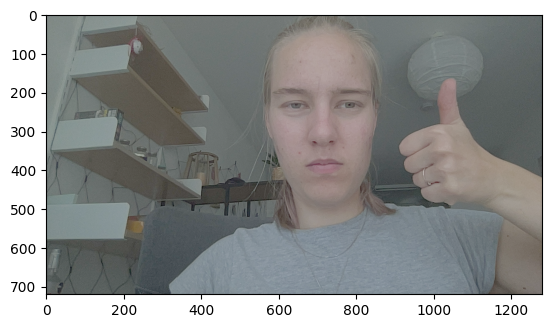

In [29]:
def adjust_gamma(image, gamma=1.0):
    inv_gamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** inv_gamma) * 255 for i in range(256)]).astype("uint8")
    return cv2.LUT(image, table)

gamma = 2.0
frame = adjust_gamma(frame, gamma)
plt.imshow(frame)

## manual cropping for demonstration purposes - you can do better!

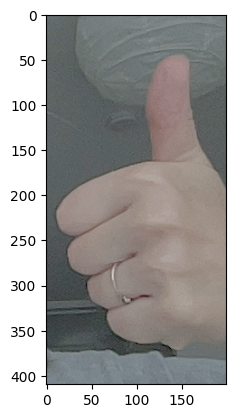

In [30]:
#plt.imshow(frame[50:350, 60:210])
plt.imshow(frame[120:530, 900:1100])

(64, 64, 3)

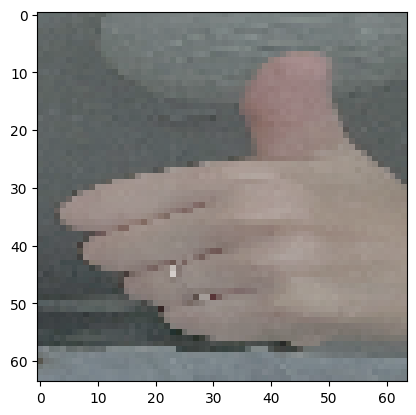

In [32]:
#resized = cv2.resize(frame[50:350, 60:210], SIZE)#[20:350, 200:420], SIZE)
resized = cv2.resize(frame[120:530, 900:1100], SIZE)#[20:350, 200:420], SIZE)
plt.imshow(resized)
resized.shape

In [33]:
reshaped = resized.reshape(-1, IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)
reshaped.shape
prediction = model.predict(reshaped)

print(label_names[np.argmax(prediction)], np.max(prediction))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
like 1.0


(9, 9, 3, 64)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.06198549..0.05258068].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07424322..0.07156104].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0750053..0.07019985].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.03951439..0.060544115].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04765456..0.042340755].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.07582505..0.04686689].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got ran

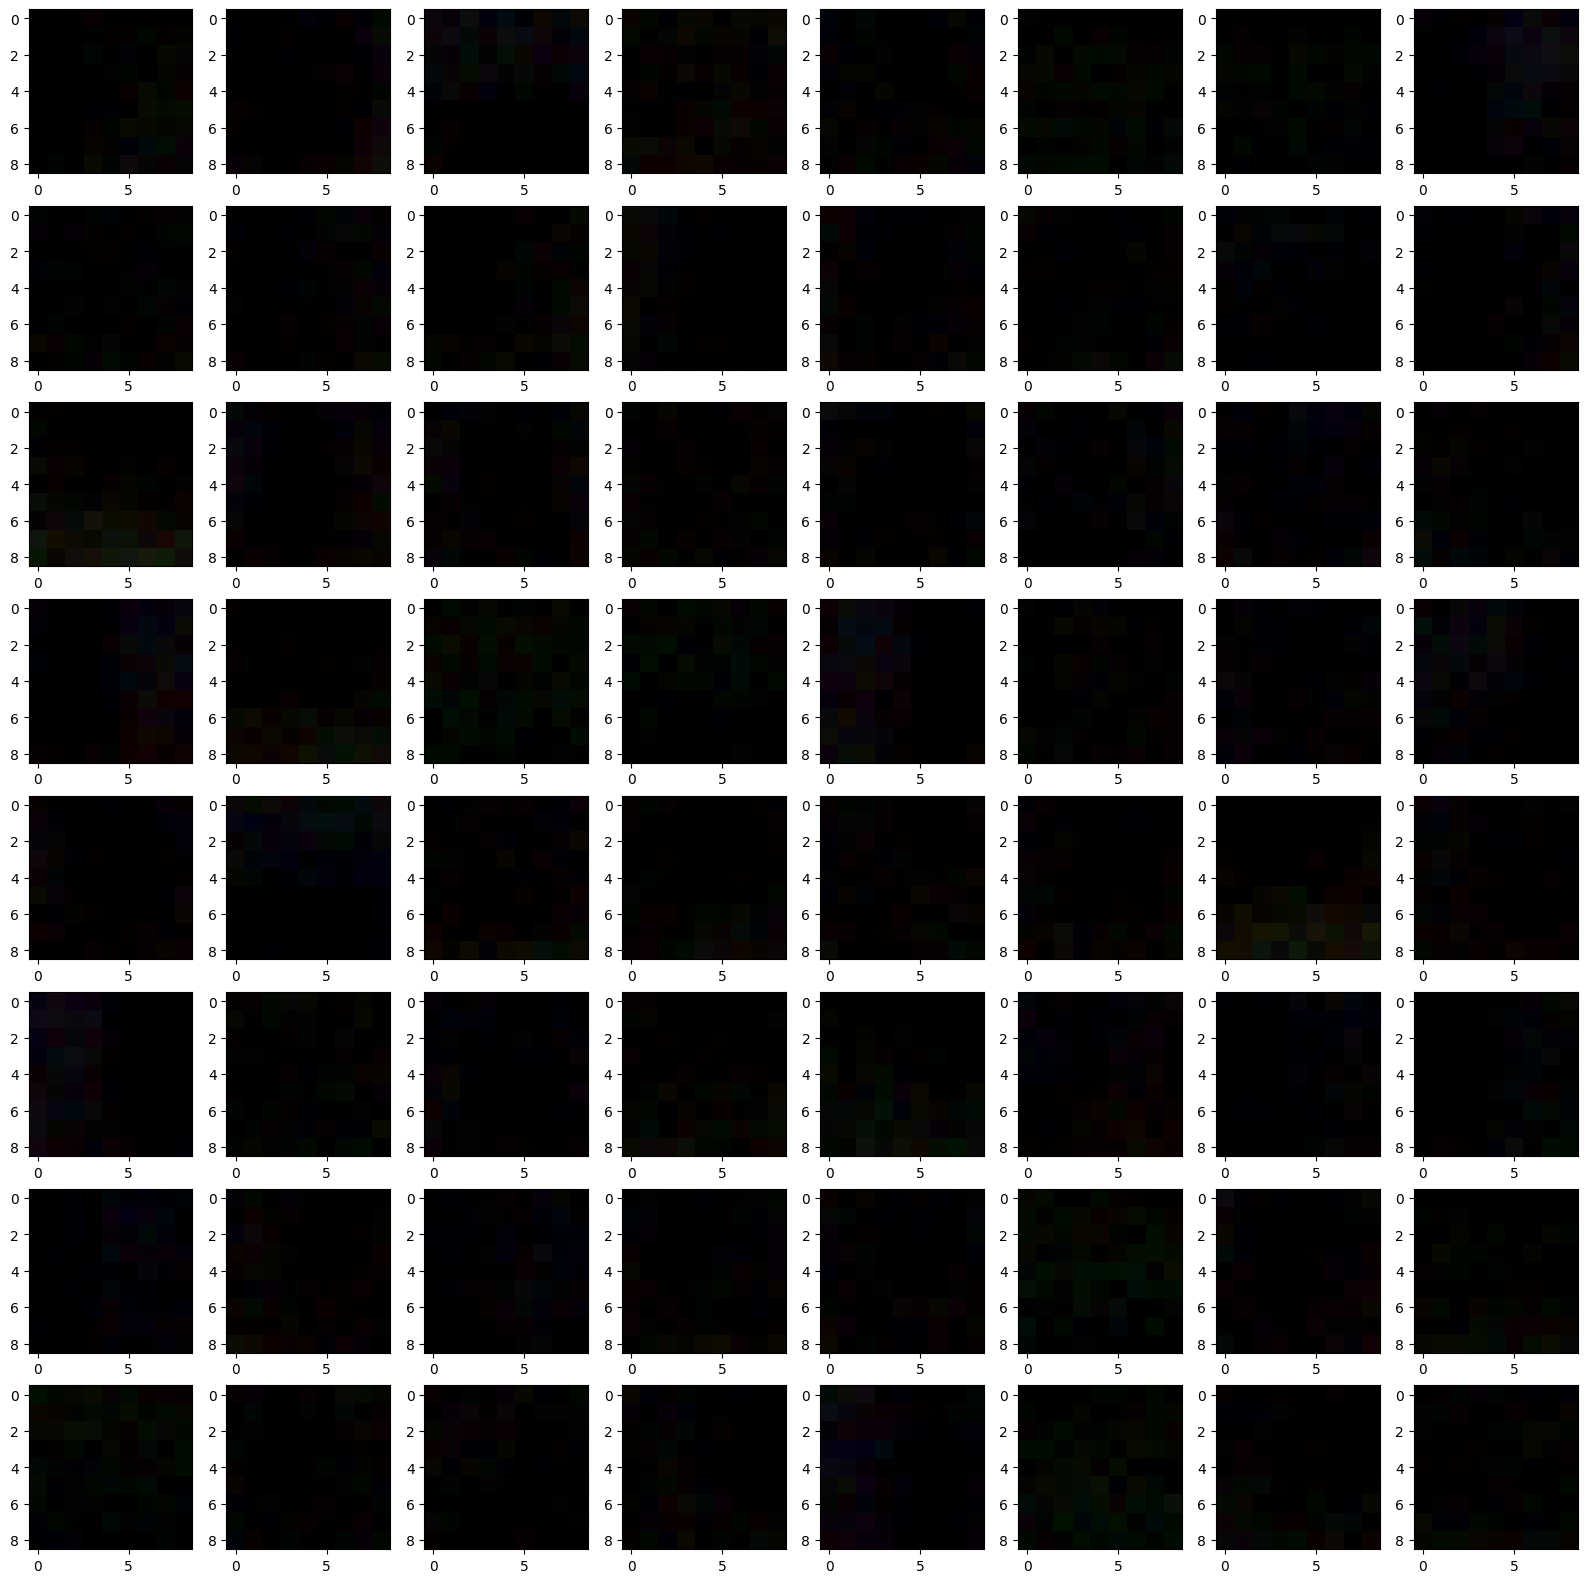

In [34]:
filters, biases = model.layers[2].get_weights()
print(filters.shape)

fig, axes = plt.subplots(8, 8, figsize=(20, 20))

for i in range(8):
    for j in range(8):
        img = filters[:,:,:,i*8+j]
        axes[i][j].imshow(img)

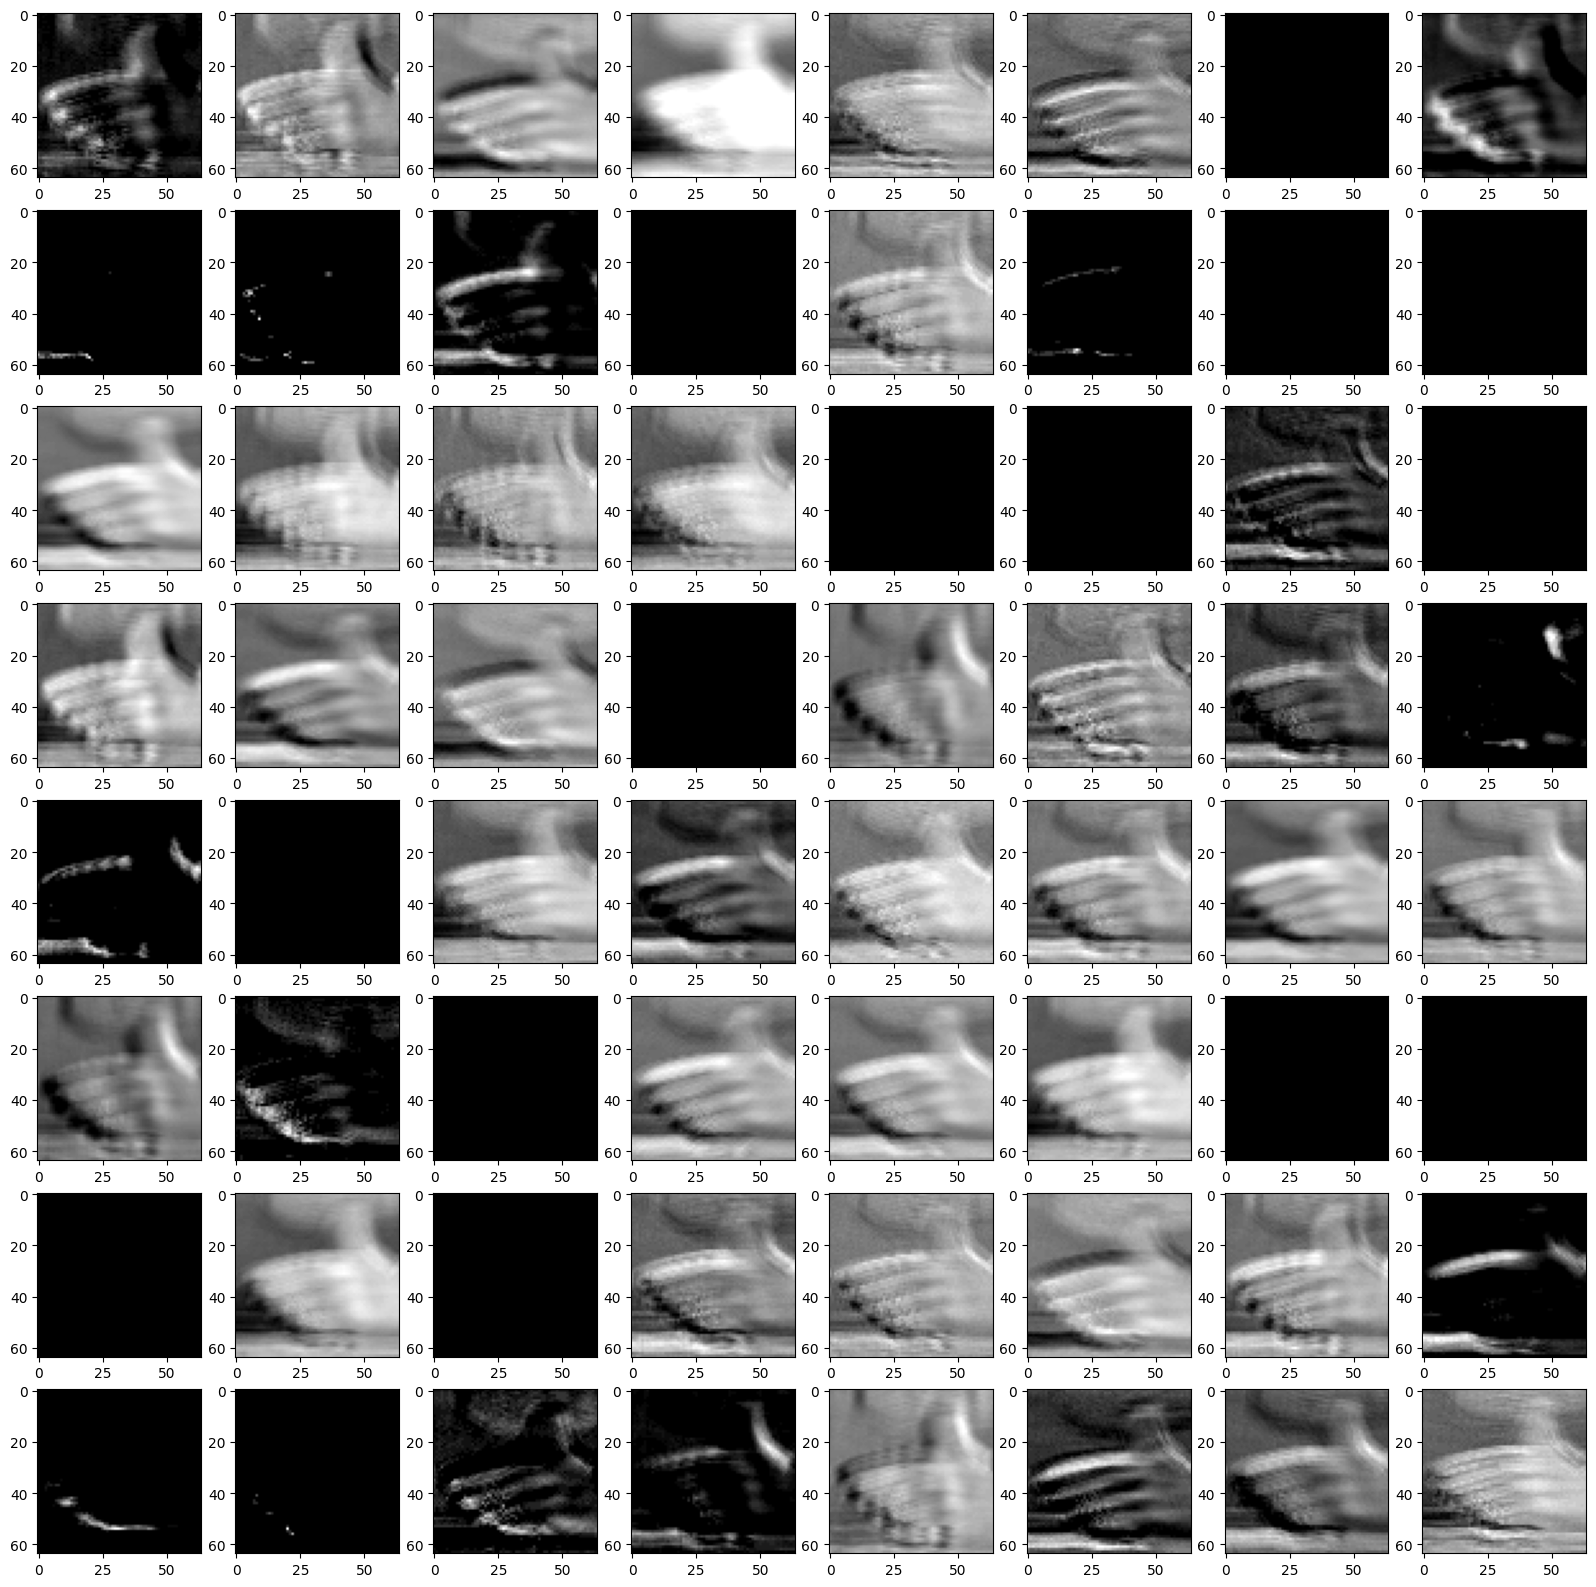

In [35]:
fig, axes = plt.subplots(8, 8, figsize=(20, 20))

for i in range(8):
    for j in range(8):
        #axes[i][j].imshow(filters[:,:,:,i*8+j] * 255, 'gray')
        kernel = filters[:,:,0,i*8+j]

        #print(kernel.shape)

        gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
        filtered = cv2.filter2D(gray, -1, kernel)

        axes[i][j].imshow(filtered, 'gray')

## Transfer Learning

let's use a pre-trained model (VGG16) for our prediction

note that VGG16 needs three color channels

In [36]:
batch_size = 8
epochs = 50
num_classes = len(label_names)
activation = 'relu'
activation_conv = 'leaky_relu'  # LeakyReLU
layer_count = 2
num_neurons = 256

# load a VGG16 model trained on the imagenet dataset
# include_top=False -> do not include the output layer
# input_tensor -> tells the model about the dimensions of our images (VGG16 needs three color channels)
# pooling -> which type of pooling to use between convolutions; max or avg seem to be the best
VGG = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(IMG_SIZE, IMG_SIZE, COLOR_CHANNELS)), pooling='max')

# we want to use the VGG's original weights -> make those layers untrainable
for layer in VGG.layers:
    layer.trainable = False

# build a new model and add the VGG layers
model_vgg = Sequential()
model_vgg.add(VGG)

# append dense layers at the end
for i in range(layer_count - 1):
    model_vgg.add(Dense(num_neurons, activation=activation))
model_vgg.add(Dropout(0.2))

model_vgg.add(Dense(num_neurons, activation=activation))

# classifier
model_vgg.add(Dense(num_classes, activation='softmax'))

model_vgg.compile(loss=categorical_crossentropy, optimizer="adam", metrics=['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_lr=0.0001)
stop_early = EarlyStopping(monitor='val_loss', patience=3)

In [37]:
history_vgg = model_vgg.fit(
    X_train,
    train_label,
    batch_size=batch_size,
    epochs=epochs,
    verbose=1,
    validation_data=(X_test, test_label),
    callbacks=[reduce_lr, stop_early]
)

Epoch 1/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 14s 211ms/step - accuracy: 0.6279 - loss: 0.8111 - val_accuracy: 0.8047 - val_loss: 0.4855 - learning_rate: 0.0010
Epoch 2/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 202ms/step - accuracy: 0.8767 - loss: 0.2922 - val_accuracy: 0.7891 - val_loss: 0.5276 - learning_rate: 0.0010
Epoch 3/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 203ms/step - accuracy: 0.9168 - loss: 0.2051 - val_accuracy: 0.8203 - val_loss: 0.4378 - learning_rate: 0.0010
Epoch 4/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 198ms/step - accuracy: 0.9674 - loss: 0.0982 - val_accuracy: 0.8984 - val_loss: 0.2769 - learning_rate: 0.0010
Epoch 5/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 200ms/step - accuracy: 0.9777 - loss: 0.0830 - val_accuracy: 0.9297 - val_loss: 0.2337 - learning_rate: 0.0010
Epoch 6/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 200ms/step - accuracy: 0.9713 - loss: 0.0724 - val_accuracy: 0.7578 - val_loss: 0.9554 - learning_rate: 0.0010
Epoch 7/50
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 199ms/step - accuracy: 0.9336 - loss: 0.

In [38]:
model_vgg.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (8, 512)               │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (8, 256)               │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (8, 256)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (8, 256)               │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (8, 3)                 │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,308,363 (58.40 MB)

 Trainable params: 197,891 (773.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 395,784 (1.51 MB)

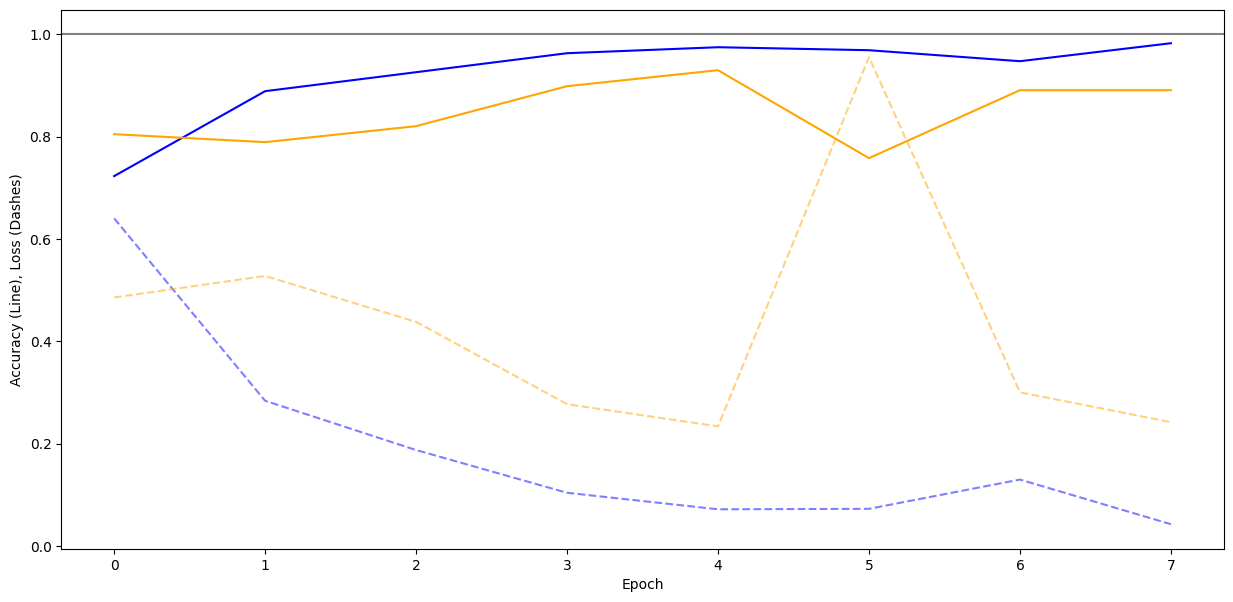

In [39]:
loss = history_vgg.history['loss']
val_loss = history_vgg.history['val_loss']
accuracy = history_vgg.history['accuracy']
val_accuracy = history_vgg.history['val_accuracy']

fig = plt.figure(figsize=(15, 7))
ax = plt.gca()

ax.set_xlabel('Epoch')
ax.set_ylabel('Accuracy (Line), Loss (Dashes)')

ax.axhline(1, color='gray')

plt.plot(accuracy, color='blue')
plt.plot(val_accuracy, color='orange')
plt.plot(loss, '--', color='blue', alpha=0.5)
plt.plot(val_loss, '--', color='orange', alpha=0.5)

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 605ms/step
before [[2.76913424e-03 5.92619665e-02 9.37968791e-01]
 [1.00000000e+00 8.09140088e-10 3.22206262e-10]
 [2.12464884e-01 6.00735247e-01 1.86799884e-01]
 [6.15405734e-04 9.98051405e-01 1.33330363e-03]
 [6.05160631e-02 9.38444555e-01 1.03936333e-03]
 [9.99837339e-01 1.47248968e-04 1.54468635e-05]
 [9.98649001e-01 1.01208477e-03 3.38886341e-04]
 [9.99962866e-01 1.51306699e-06 3.56710261e-05]
 [9.99699831e-01 2.83219735e-04 1.69318573e-05]
 [1.10675566e-04 9.96344805e-01 3.54457484e-03]
 [1.82194393e-02 4.88700271e-01 4.93080199e-01]
 [9.99999762e-01 8.00591522e-08 9.35126181e-08]
 [2.92048367e-06 9.99641180e-01 3.55859695e-04]
 [5.46899624e-03 9.74216580e-01 2.03144252e-02]
 [8.98426771e-01 7.03742132e-02 3.11990473e-02]
 [2.32291326e-01 4.53349829e-01 3.14358890e-01]
 [4.95201427e-08 5.41972213e-06 9.99994516e-01]
 [2.37272889e-05 1.45655922e-05 9.99961793e-01]
 [9.99960959e-01 3.56520504e-05 3.47984633e-06]
 [3.08682070e-06 1.71449574e-05 9.99979794

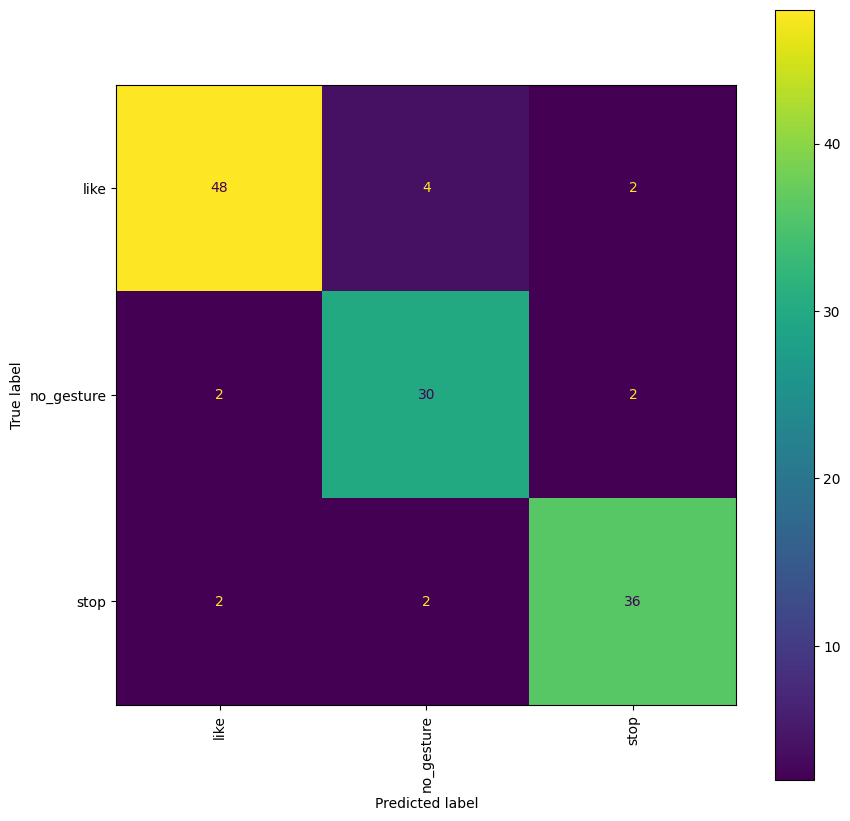

In [40]:
# let the model make predictions for our training data
y_predictions = model_vgg.predict(X_test)

# we get a 2D numpy array with probabilities for each category
print('before', y_predictions)

# to build a confusion matrix, we have to convert it to classifications
# this can be done by using the argmax() function to set the probability to 1 and the rest to 0
y_predictions = np.argmax(y_predictions, axis=1)

print('probabilities', y_predictions)

# create and plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_predictions)

fig = plt.figure(figsize=(10, 10))

ConfusionMatrixDisplay(conf_matrix, display_labels=label_names).plot(ax=plt.gca())

plt.xticks(rotation=90, ha='center')
pass